# `multidms` fitting pipeline

Here, we demonstrate the pipeline for fitting a `multidms` model on some data using the tools available in the package. Currently, we show how to pre-process data from various dms experiments targeting Delta and Omicron spike protein homologs.

In [1]:
# built-in libraries
import os
import sys
from itertools import combinations
from collections import defaultdict
import time

# external dependencies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as onp
from tqdm.notebook import tqdm
import jax.numpy as jnp

import multidms
%load_ext autoreload
%autoreload 2
%matplotlib inline

**Read in the dms data and list all available experimental conditions**

In [2]:
func_score_data = pd.DataFrame()
sites = {}
wt_seqs = {}

for homolog in ["Delta", "Omicron_BA.1", "Omicron_BA.2"]:
    
    # functional scores
    func_sel = pd.read_csv(f"../results/{homolog}/functional_selections.csv")
    func_sel = func_sel.assign(
        filename = f"../results/{homolog}/" + 
        func_sel.library + "_" + 
        func_sel.preselection_sample + 
        "_vs_" + func_sel.postselection_sample + 
        "_func_scores.csv"
    )
    func_sel = func_sel.assign(
        func_sel_scores_df = func_sel.filename.apply(lambda f: pd.read_csv(f))
    )
    func_sel = func_sel.assign(
        len_func_sel_scores_df = func_sel.func_sel_scores_df.apply(lambda x: len(x))
    )
    fun_sel = func_sel.assign(homolog = homolog)
    func_score_data = pd.concat([func_score_data, fun_sel]).reset_index(drop=True)

# Add a column that gives a unique ID to each homolog/DMS experiment
func_score_data['condition'] = func_score_data.apply(
    lambda row: f"{row['homolog']}-{row['library']}".replace('-Lib',''),
#     lambda row: f"{row['homolog']}-{row['library']}-{row['replicate']}".replace('-Lib',''),
    axis=1
)
func_score_data

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,len_func_sel_scores_df,homolog,condition
0,2021-10-28_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1,Lib-1_2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,45131,Delta,Delta-1
1,2021-10-28_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2,Lib-1_2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,45131,Delta,Delta-1
2,2021-10-28_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1,Lib-3_2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3
3,2021-10-28_thaw-1_VSVG_control_2,Lib-3,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2,Lib-3_2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3
4,2021-10-28_thaw-1_VSVG_control_1,Lib-4,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1,Lib-4_2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4
5,2021-10-28_thaw-1_VSVG_control_2,Lib-4,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2,Lib-4_2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4
6,2021-10-28_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1,Lib-2_2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2
7,2021-10-28_thaw-1_VSVG_control_2,Lib-2,thaw-1,2,2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2,Lib-2_2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2
8,2022-03-25_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1,Lib-1_2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,94347,Omicron_BA.1,Omicron_BA.1-1
9,2022-03-25_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2,Lib-1_2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,94347,Omicron_BA.1,Omicron_BA.1-1


**Define all the knobs which define the pipeline's pre-preprocessing behavior**

In [243]:
prep_params = {
    # pre-processing params
    "scale_counts" : False,
    "min_pre_counts" : 100,
    "pseudocount" : 0.1,
    "sample" : False, #5000,
    "min_pre_counts" : 100,
    "clip_target" : (-3.5, 2.5),
    "trim" : False,
    "reference_condition" : "Omicron_BA.1-3",
    "conditions" : [
        "Delta-4",# "Delta-4",
        "Omicron_BA.1-3",#"Omicron_BA.1-3",
        "Omicron_BA.2-2",#"Omicron_BA.2-2"
    ]
}

[autoreload of multidms.plot failed: Traceback (most recent call last):
  File "/home/jgallowa/miniconda3/envs/multidms_toml/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/home/jgallowa/miniconda3/envs/multidms_toml/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/home/jgallowa/miniconda3/envs/multidms_toml/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/jgallowa/Projects/multidms/multidms/plot.py", line 678


In [244]:
# uncomment to reset or if first time running notebook
# datasets = pd.DataFrame(columns=list(prep_params.keys()) + ["data"])

In [245]:
# datasets

## Pre-Proccessing

**Query the conditions to be included in a fit**

In [246]:
func_score_data_sub = func_score_data.query(
    f"condition.isin({list(prep_params['conditions'])})"
)
# func_score_data_sub = func_score_data.query(
#     f"condition == 'Delta-3'"
# )
func_score_data_sub

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,len_func_sel_scores_df,homolog,condition
4,2021-10-28_thaw-1_VSVG_control_1,Lib-4,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1,Lib-4_2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4
5,2021-10-28_thaw-1_VSVG_control_2,Lib-4,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2,Lib-4_2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4
11,2022-06-22_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2022-06-22_thaw-1_no-antibody_control_1,Lib-3_2022-06-22_thaw-1_VSVG_control_1,Lib-3_2022-06-22_thaw-1_no-antibody_control_1,Lib-3_2022-06-22_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.1/Lib-3_2022-06-22_thaw-...,library pre_samp...,125127,Omicron_BA.1,Omicron_BA.1-3
13,2022-10-22_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2022-10-22_thaw-1_no-antibody_control_1,Lib-2_2022-10-22_thaw-1_VSVG_control_1,Lib-2_2022-10-22_thaw-1_no-antibody_control_1,Lib-2_2022-10-22_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.2/Lib-2_2022-10-22_thaw-...,library pre_sampl...,85210,Omicron_BA.2,Omicron_BA.2-2
15,2022-10-22_thaw-2_VSVG_control_1,Lib-2,thaw-2,2,2022-10-22_thaw-2_no-antibody_control_1,Lib-2_2022-10-22_thaw-2_VSVG_control_1,Lib-2_2022-10-22_thaw-2_no-antibody_control_1,Lib-2_2022-10-22_thaw-2_VSVG_control_1_vs_2022...,../results/Omicron_BA.2/Lib-2_2022-10-22_thaw-...,library pre_sampl...,85210,Omicron_BA.2,Omicron_BA.2-2


In [247]:
func_score_df = pd.DataFrame()
for idx, row in tqdm(func_score_data_sub.iterrows(), total=len(func_score_data_sub)):
    df = row.func_sel_scores_df.assign(homolog=row.homolog)
    df = df.assign(library = row.library)
    df = df.assign(replicate = row.replicate)
    exp_func_score_df = df.assign(condition=row.condition)
    func_score_df = pd.concat([func_score_df, exp_func_score_df])
func_score_df = func_score_df.rename({"aa_substitutions_reference":"aa_substitutions"}, axis=1).reset_index(drop=True)
func_score_df.head()

  0%|          | 0/5 [00:00<?, ?it/s]

,library,pre_sample,post_sample,barcode,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_codon_substitutions,aa_substitutions_sequential,n_aa_substitutions,aa_substitutions,pre_count_threshold,homolog,replicate,condition
0,Lib-4,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,AAAAGCAGTGTAAATT,-0.6002,0.0005,16073,5577,2036762,1071396,0.5,2,V443A V1126F,2,V445A V1128F,25,Delta,1,Delta-4
1,Lib-4,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,CAACTGAATTGCTCCA,0.3317,0.0004,12243,8105,2036762,1071396,0.5,1,NaN,0,NaN,25,Delta,1,Delta-4
2,Lib-4,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,CAGCAAAGAATATGCC,-0.4631,0.0007,10528,4017,2036762,1071396,0.5,5,D80Y V685I G767A M1235I C1245Y,5,D80Y V687I G769A M1237I C1247Y,25,Delta,1,Delta-4
3,Lib-4,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,CTCTCCCTATCAAAAG,-0.3864,0.0008,9344,3760,2036762,1071396,0.5,2,G197A S756G,2,G199A S758G,25,Delta,1,Delta-4
4,Lib-4,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,GATCAATCATTTGCCG,0.2973,0.0006,8747,5654,2036762,1071396,0.5,0,NaN,0,NaN,25,Delta,1,Delta-4


**Optionally subset the variants**

In [248]:
if prep_params["sample"]:
    func_score_df = func_score_df.sample(prep_params["sample"])

**remove all variants with string sites and stop codon wildtypes**

In [249]:
func_score_df.aa_substitutions.fillna("", inplace=True)
gapped_sub_vars = []
stop_wt_vars = []
non_numeric_sites = []
for idx, row in tqdm(func_score_df.iterrows(), total=len(func_score_df)):
#     if "-" in row["aa_substitutions"]:
#         gapped_sub_vars.append(idx)
    for sub in row["aa_substitutions"].split():
        if sub[0] == "*":
            stop_wt_vars.append(idx)
        if not sub[-2].isnumeric():
            non_numeric_sites.append(idx)

to_drop = set.union(set(gapped_sub_vars), set(stop_wt_vars), set(non_numeric_sites))
func_score_df.drop(to_drop, inplace=True)

  0%|          | 0/374935 [00:00<?, ?it/s]

**Drop all variants with pre-counts below a threshold.**

In [250]:
# Drop barcoded variants with pre-counts below a threshold
n_pre_threshold = len(func_score_df)
func_score_df = func_score_df[func_score_df['pre_count'] >= prep_params["min_pre_counts"]]
print(f"Of {n_pre_threshold} variants, {n_pre_threshold - len(func_score_df)} had fewer than {prep_params['min_pre_counts']} counts before selection, and were filtered out")

Of 370142 variants, 36232 had fewer than 100 counts before selection, and were filtered out


In [251]:
func_score_df

,library,pre_sample,post_sample,barcode,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_codon_substitutions,aa_substitutions_sequential,n_aa_substitutions,aa_substitutions,pre_count_threshold,homolog,replicate,condition
0,Lib-4,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,AAAAGCAGTGTAAATT,-0.6002,0.0005,16073,5577,2036762,1071396,0.5,2,V443A V1126F,2,V445A V1128F,25,Delta,1,Delta-4
1,Lib-4,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,CAACTGAATTGCTCCA,0.3317,0.0004,12243,8105,2036762,1071396,0.5,1,NaN,0,,25,Delta,1,Delta-4
2,Lib-4,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,CAGCAAAGAATATGCC,-0.4631,0.0007,10528,4017,2036762,1071396,0.5,5,D80Y V685I G767A M1235I C1245Y,5,D80Y V687I G769A M1237I C1247Y,25,Delta,1,Delta-4
3,Lib-4,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,CTCTCCCTATCAAAAG,-0.3864,0.0008,9344,3760,2036762,1071396,0.5,2,G197A S756G,2,G199A S758G,25,Delta,1,Delta-4
4,Lib-4,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,GATCAATCATTTGCCG,0.2973,0.0006,8747,5654,2036762,1071396,0.5,0,NaN,0,,25,Delta,1,Delta-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361736,Lib-2,2022-10-22_thaw-2_VSVG_control_1,2022-10-22_thaw-2_no-antibody_control_1,TGGACGAGAAATCCAG,-0.1622,0.0356,100,139,6478978,10063399,0.5,1,E468Q,1,E471Q,56,Omicron_BA.2,2,Omicron_BA.2-2
361737,Lib-2,2022-10-22_thaw-2_VSVG_control_1,2022-10-22_thaw-2_no-antibody_control_1,TTACACAAAACGTGTG,0.5809,0.0296,100,233,6478978,10063399,0.5,1,K1188S,1,K1191S,56,Omicron_BA.2,2,Omicron_BA.2-2
361738,Lib-2,2022-10-22_thaw-2_VSVG_control_1,2022-10-22_thaw-2_no-antibody_control_1,TTCATAAAAATTTCAA,1.5701,0.0252,100,463,6478978,10063399,0.5,1,L10I,1,L10I,56,Omicron_BA.2,2,Omicron_BA.2-2
361739,Lib-2,2022-10-22_thaw-2_VSVG_control_1,2022-10-22_thaw-2_no-antibody_control_1,TTCCCTGCAATAATTC,1.3412,0.0260,100,395,6478978,10063399,0.5,3,G72C L365I A1219S,3,G75C L368I A1222S,56,Omicron_BA.2,2,Omicron_BA.2-2


**Optionally, scale the counts**

In [252]:
if prep_params['scale_counts']:
    func_score_df = multidms.utils.scale_func_score(func_score_df)

In [253]:
func_score_df.columns

Index(['library', 'pre_sample', 'post_sample', 'barcode', 'func_score',
       'func_score_var', 'pre_count', 'post_count', 'pre_count_wt',
       'post_count_wt', 'pseudocount', 'n_codon_substitutions',
       'aa_substitutions_sequential', 'n_aa_substitutions', 'aa_substitutions',
       'pre_count_threshold', 'homolog', 'replicate', 'condition'],
      dtype='object')

In [254]:
func_score_df = func_score_df[['func_score', 'aa_substitutions', 'condition']].copy()

**Optionally, clip the target functional scores**

In [255]:
if prep_params['clip_target'] and prep_params['trim']:
    l,h = prep_params['clip_target']
    func_score_trim = func_score_df.query(
        f"(func_score >= {l}) & (func_score <= {h})"
    )
    diff = len(func_score_df) - len(func_score_trim)
    print(f"Of {len(func_score_df)} variants, {diff} were thrown during trimming")
    func_score_df = func_score_trim

In [256]:
if prep_params['clip_target'] and not prep_params['trim']:
    func_score_df['func_score'] = func_score_df['func_score'].clip(*prep_params['clip_target'])

In [257]:
func_score_df["condition"] = func_score_df.condition.replace(
    {
        "Delta-4":"Delta", 
         "Omicron_BA.1-3":"Omicron_BA1", 
         "Omicron_BA.2-2":"Omicron_BA2"
    }
)

In [258]:
func_score_df["condition"].unique()

array(['Delta', 'Omicron_BA1', 'Omicron_BA2'], dtype=object)

In [259]:
# func_score_df.to_csv("Delta_BA1_BA2_func_score_df.csv")

In [260]:
# for cond, cond_df in func_score_df.groupby("condition"):
#     print(cond_df["aa_substitutions"].value_counts())

## `MultiDmsData`

**After the functional score dataframe for all variants has been prepped, you can now initialize a `mulidms.MultiDmsData` Object. This will (1) convert substitution string to be with respect to a reference (if necessary) (2) set static attributes and (3) prep model training data which can be shared by multiple `multidms.MulitDmsModel` objects.**

In [261]:
# uncomment to see docs
# help(multidms.MultiDmsData)

In [262]:
# datasets

In [263]:
# tqdm.pandas()
start = time.time()
data = multidms.MultiDmsData(
    func_score_df,
    alphabet= multidms.AAS_WITHSTOP_WITHGAP,
    condition_colors = sns.color_palette("Paired"),
    reference="Omicron_BA1",
    assert_site_integrity = False,
    verbose=False
#     nb_workers=None
)
end = time.time()
print(f"Finished, time: {round(end-start)}")

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Finished, time: 41


In [264]:
# datasets = pd.DataFrame()

**To analyze multiple datasets, we store the data object along with it's defining features in a dataframe.**

In [265]:
data_row = pd.Series(prep_params).to_frame().T
data_row['data'] = data
datasets = pd.concat([datasets, data_row], ignore_index=True)
datasets

,scale_counts,min_pre_counts,pseudocount,sample,clip_target,trim,reference_condition,conditions,data
0,False,100,0.1,False,"(-3.5, 2.5)",False,Omicron_BA.1-2,"[Delta-3, Omicron_BA.1-2, Omicron_BA.2-1]",<multidms.data.MultiDmsData object at 0x7f1d0e...
1,False,100,0.1,False,"(-3.5, 2.5)",False,Omicron_BA.1-3,"[Delta-4, Omicron_BA.1-3, Omicron_BA.2-2]",<multidms.data.MultiDmsData object at 0x7f1361...


In [266]:
datasets.loc[0, "data"].site_map.loc[[95, 142], :]

,Delta,Omicron_BA1,Omicron_BA2
95,T,I,T
142,D,D,D


In [267]:
datasets.loc[0, "data"].non_identical_mutations

frozendict.frozendict({'Delta': 'T19R V67A I95T E156G I212L D339G L371S P373S F375S N417K K440N S446G L452R N477S A484E R493Q S496G R498Q Y501N H505Y K547T Y655H K679N H681R K764N Y796D K856N D950N H954Q K969N F981L', 'Omicron_BA1': '', 'Omicron_BA2': 'T19I A27S V67A I95T I212L V213G L371F T376A D405N R408S S446G S496G K547T K856N F981L'})

In [268]:
# datasets.loc[3, "data"]._collapse_identical_variants

In [277]:
datasets

,scale_counts,min_pre_counts,pseudocount,sample,clip_target,trim,reference_condition,conditions,data
0,False,100,0.1,False,"(-3.5, 2.5)",False,Omicron_BA.1-2,"[Delta-3, Omicron_BA.1-2, Omicron_BA.2-1]",<multidms.data.MultiDmsData object at 0x7f1d0e...
1,False,100,0.1,False,"(-3.5, 2.5)",False,Omicron_BA.1-3,"[Delta-4, Omicron_BA.1-3, Omicron_BA.2-2]",<multidms.data.MultiDmsData object at 0x7f1361...


## `MultiDmsModel`

**To fit a mopdel, we first choose a dataset(s) we would like to fit**

In [270]:
# un-comment to re-initialize results
models = defaultdict(list)

**Next, we iterate through datasets and model definitions of interest and (1) initialize a model object with the respective dataset (2) fit that data to a model with some given hyperparameters and (3) save the models in a dataframe for comparison and plotting.**

In [271]:
import multidms.model as model
for dataset in datasets.index:
    for ge_func in [model.sigmoidal_global_epistasis]:
        for output_act in [model.softplus_activation]:
            
            imodel = multidms.MultiDmsModel(
                    datasets.loc[dataset, 'data'],
                    epistatic_model=ge_func,
                    output_activation=output_act,
                    n_percep_units=10
            )
            
            start = time.time()
            imodel.fit(lasso_shift=1e-5, maxiter=5000, tol=1e-6)
            end = time.time()
            print(f"done. fitting time = {round(end - start)} seconds")
            
            models["model"].append(imodel)
            models["dataset"].append(dataset)
            
models_df = pd.DataFrame(models)
models_df.tail(20)

done. fitting time = 64 seconds
done. fitting time = 63 seconds


,model,dataset
0,<multidms.model.MultiDmsModel object at 0x7f13...,0
1,<multidms.model.MultiDmsModel object at 0x7f13...,1


### Visualization

**The one mutable attribute of MultiDmsData objects is the condition_colors. We will set a custom color patte to be shared across datasets such that our multiple fit plots are consistant.**

In [279]:
models_df.loc[0, "model"].data.site_map

,Delta,Omicron_BA1,Omicron_BA2
1,M,M,M
2,F,F,F
3,V,V,V
4,F,F,F
5,L,L,L
...,...,...,...
1248,C,C,C
1249,S,S,S
1250,C,C,C
1251,G,G,G


In [280]:
moi1 = models_df.loc[0, "model"]
moi2 = models_df.loc[1, "model"]
import multidms.plot

In [281]:
print(moi1.params.keys())

dict_keys(['C_Delta', 'C_Omicron_BA1', 'C_Omicron_BA2', 'C_ref', 'S_Delta', 'S_Omicron_BA1', 'S_Omicron_BA2', 'α', 'β', 'γ_Delta', 'γ_Omicron_BA1', 'γ_Omicron_BA2'])


In [320]:
moi1.data.non_identical_sites

frozendict.frozendict({'Delta':     Omicron_BA1 Delta
19            T     R
67            V     A
95            I     T
156           E     G
212           I     L
339           D     G
371           L     S
373           P     S
375           F     S
417           N     K
440           K     N
446           S     G
452           L     R
477           N     S
484           A     E
493           R     Q
496           S     G
498           R     Q
501           Y     N
505           H     Y
547           K     T
655           Y     H
679           K     N
681           H     R
764           K     N
796           Y     D
856           K     N
950           D     N
954           H     Q
969           K     N
981           F     L, 'Omicron_BA1': [], 'Omicron_BA2':     Omicron_BA1 Omicron_BA2
19            T           I
27            A           S
67            V           A
95            I           T
212           I           L
213           V           G
371           L           F
376  

In [371]:
chart = multidms.plot.mut_shift_plot({"rep1":moi1, "rep2":moi2}, include_beta=False)
chart

/home/jgallowa/miniconda3/envs/multidms_toml/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [ ]:
assert chart.query("prefix")

In [120]:
import matplotlib.colors as colors

palette = [
    '#BFBFBF','#404040',
    '#F97306', '#FFA500',
    '#9400D3', '#EE82EE',
]

conditions = [
    "Delta-2", "Delta-3",
    "Omicron_BA.1-2", "Omicron_BA.1-3",
    "Omicron_BA.2-1", "Omicron_BA.2-2"
]
cc = {con:tuple(colors.to_rgb(col)) for con, col in zip(conditions, palette)}

for row, values in datasets.iterrows():
    values.data.condition_colors = cc

In [219]:
chart = models_df.loc[0, "model"].mut_shift_plot(times_seen_threshold=3)
chart.save(f"BA1-reference-with-gaps.html")
# chart

/home/jgallowa/miniconda3/envs/multidms_toml/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


In [222]:
mut_df = models_df.loc[0, "model"].mutations_df
times_seen_cols = [c for c in mut_df.columns if "times" in c]
f_cols = [c for c in mut_df.columns if "F_" in c]
for c in times_seen_cols:
    mut_df = mut_df[mut_df[c] >= 0]
mut_df.drop(times_seen_cols + f_cols, axis=1, inplace=True)
mut_df.head()
mut_df.to_csv(f"BA1-reference_mut_df.csv")

In [121]:
# chart = models_df.loc[0, "model"].mut_shift_plot()
# chart.save(f"Delta-lib2-BA1-lib2_BA2-lib1.html")
# chart

In [122]:
# chart = models_df.loc[1, "model"].mut_shift_plot()
# chart.save(f"Delta-lib3-BA1-lib3_BA2-lib2.html")
# chart

In [123]:
# chart = models_df.loc[2, "model"].mut_shift_plot()
# chart.save(f"BA1-lib3_BA2-lib2.html")
# chart

In [124]:
# chart = models_df.loc[3, "model"].mut_shift_plot()
# chart.save(f"BA1-lib2_BA2-lib1.html")
# chart

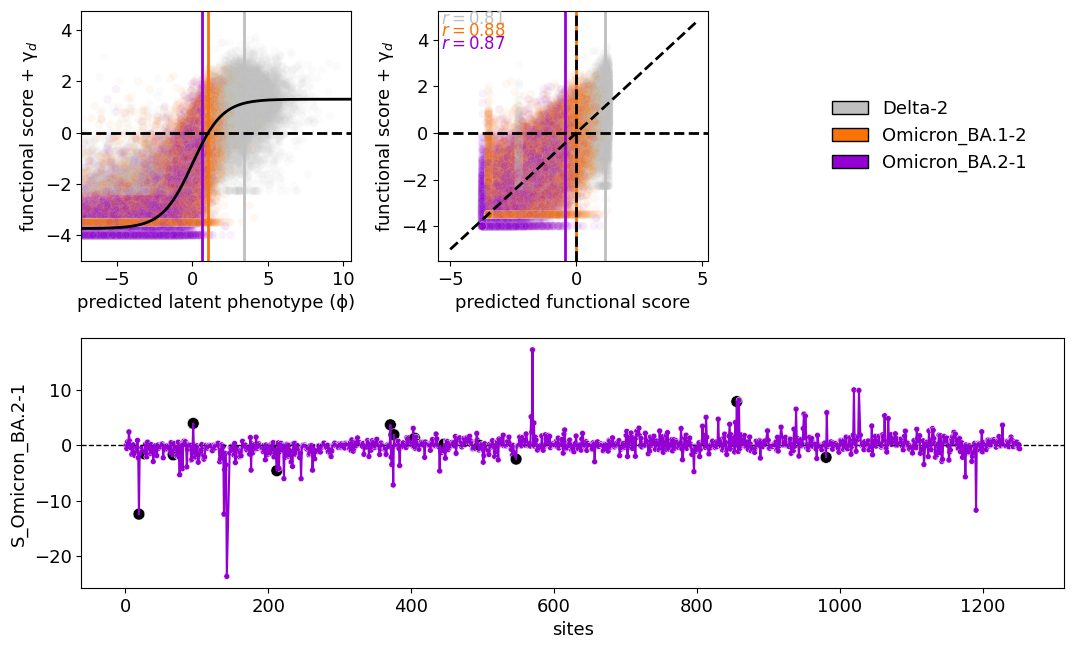

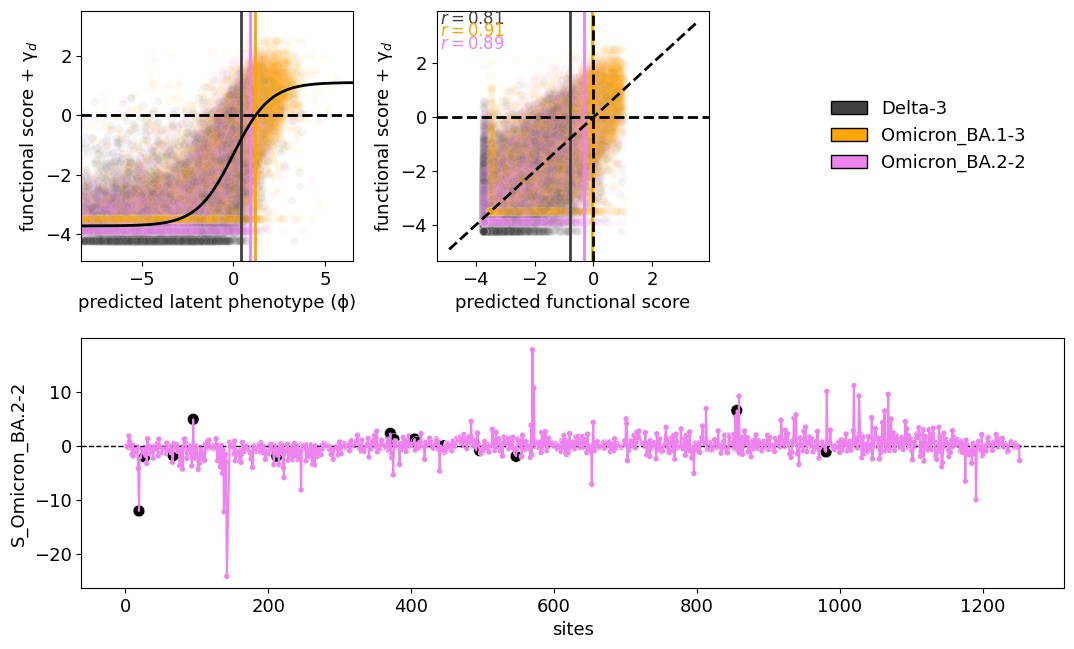

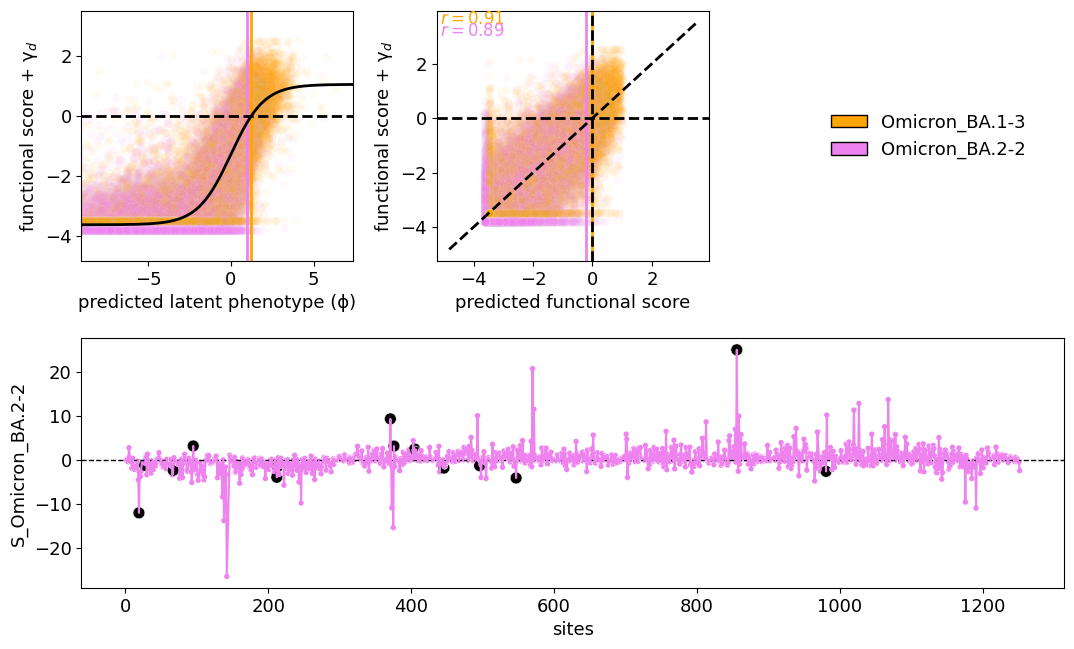

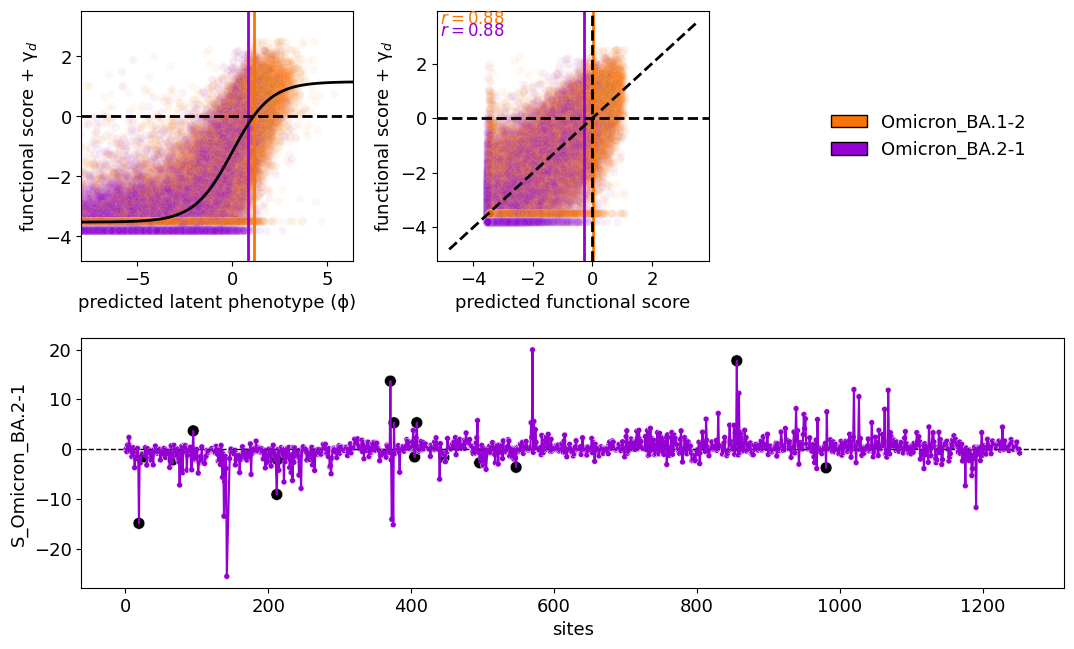

In [127]:
%matplotlib inline
import matplotlib.colors as colors
plt.rcParams.update({'font.size': 13})

for m in [0,1,2,3]:
    model = models_df.loc[m, "model"]

    fig = plt.figure(constrained_layout=True, figsize=[11,6.5])
    axd = fig.subplot_mosaic(
        """
        ABC
        DDD
        """,
        empty_sentinel="X"
    )
    non_ref_cond = list(set(model.data.conditions) - set([model.data.reference]))
    
    
    model.plot_epistasis(ax=axd["A"], alpha=0.05, show=False, legend=False)
    model.plot_pred_accuracy(ax=axd["B"], alpha=0.05, show=False, legend=False)
    
    for nrc in non_ref_cond:
        if "BA.2" in nrc:
            model.plot_shifts_by_site(nrc, show=False, ax=axd["D"], agg_func=onp.sum)
    
    conditions = sorted(model.data.conditions)
    axd["C"].axis('off')
    legend_elements = [
        patches.Patch(
             facecolor=cc[cond], 
             edgecolor="black", 
             label=cond
        )
        for cond in conditions
    ]
    axd["C"].legend(
            handles=legend_elements, 
            loc='center',
            frameon=False
    )
    plt.show()

In [144]:
plt.rcParams.update({'font.size': 13})

from functools import reduce
mutations_dfs = []
for model in [0,1,2,3]:
    
    mut_df = models_df.loc[model, "model"].mutations_df.set_index("mutation")
    
    new_column_name_map = {c:f"{c}_{model}" for c in mut_df.columns}
    mut_df = mut_df.rename(new_column_name_map, axis=1)
    times_seen_cols = [c for c in mut_df.columns if "times" in c]
    for c in times_seen_cols:
        mut_df = mut_df[mut_df[c] >= 0]
    mutations_dfs.append(mut_df)
    

df_merged = reduce(
    lambda  left,right: pd.merge(
        left,
        right,
        left_index=True, 
        right_index=True,
        how='inner'
    ), 
    mutations_dfs
)
df_merged.head()

df_merged = df_merged.assign(is_stop = [True if "*" in mut else False for mut in df_merged.index])

In [145]:
df_merged.head()

,wts_0,sites_0,muts_0,times_seen_Delta-2_0,times_seen_Omicron_BA.1-2_0,times_seen_Omicron_BA.2-1_0,β_0,S_Delta-2_0,F_Delta-2_0,S_Omicron_BA.1-2_0,...,sites_3,muts_3,times_seen_Omicron_BA.1-2_3,times_seen_Omicron_BA.2-1_3,β_3,S_Omicron_BA.1-2_3,F_Omicron_BA.1-2_3,S_Omicron_BA.2-1_3,F_Omicron_BA.2-1_3,is_stop
mutation,,,,,,,,,,,,,,,,,,,,,
M1I,M,1,I,3.0,5.0,6.0,-3.481352,0.160752,-2.274553,0.0,...,1,I,6.0,6.0,-4.754655,0.0,-3.369919,0.008553,-3.399020,False
M1T,M,1,T,0.0,7.0,2.0,-4.814432,0.000000,-2.274558,0.0,...,1,T,7.0,2.0,-4.953530,0.0,-3.384907,0.004169,-3.420444,False
M1V,M,1,V,13.0,1.0,0.0,-3.470561,-0.590477,-2.274558,0.0,...,1,V,1.0,0.0,-0.666848,0.0,-0.661713,0.000000,-0.661713,False
F2L,F,2,L,7.0,12.0,19.0,0.283172,-0.059999,0.208387,0.0,...,2,L,12.0,19.0,0.269336,0.0,0.223351,-0.450379,-0.158585,False
F2S,F,2,S,3.0,8.0,10.0,0.437799,0.090750,0.447481,0.0,...,2,S,8.0,10.0,0.350887,0.0,0.282827,-0.078400,0.225704,False


In [146]:
ba2_params = [c for c in df_merged.columns if "S_Omicron_BA.2" in c]
df_merged[ba2_params].head()

,S_Omicron_BA.2-1_0,S_Omicron_BA.2-2_1,S_Omicron_BA.2-2_2,S_Omicron_BA.2-1_3
mutation,,,,
M1I,-0.007465,0.051277,0.158500,0.008553
M1T,-0.014563,0.123932,-0.009400,0.004169
M1V,0.000000,0.000000,0.000000,0.000000
F2L,-0.459501,0.043301,-0.063751,-0.450379
F2S,-0.110590,-0.010582,-0.052797,-0.078400


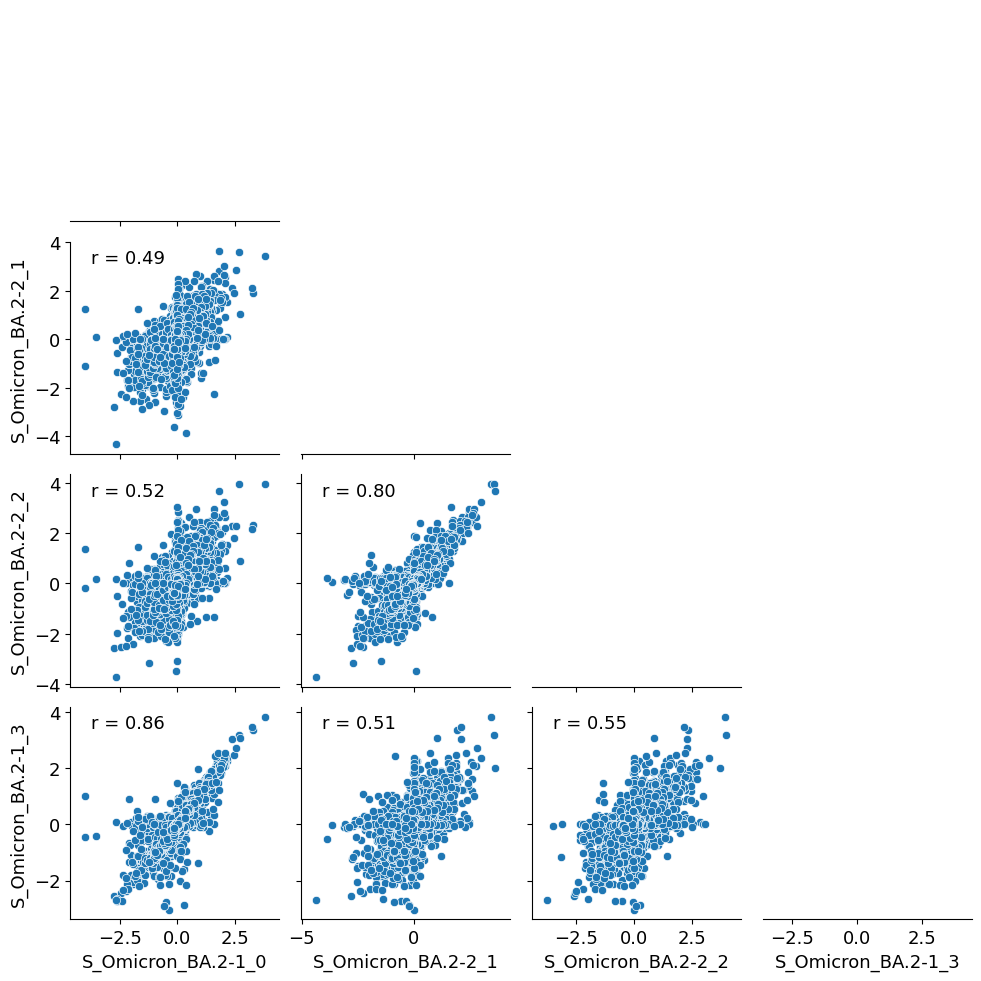

In [147]:
from scipy.stats import pearsonr

def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'r = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    
# def hide_current_axis(*args, **kwds):
#     plt.gca().axis('off')

g = sns.pairplot(
    df_merged[ba2_params], 
    corner=True, 
    diag_kind="kde",
    diag_kws={"linewidth": 0, "fill": False}
)
g.map_lower(corrfunc)

plt.show()